# TP1: Introduction to CNN denoising

### Name: **Waël Doulazmi**


The objective of this lesson is to explore some basic aspects of convolutional neuronal networks (CNN) applied to denoising. We will show how to define and train a network in pytorch. As our first network, we are going to implement DCT denoising as a CNN.

We will cover the following topics:
* Define a simple CNN model inspired on DCT denoising
* Apply a CNN to an image
* Training a CNN

There are <font color='blue'>**9 questions**</font> in the notebook and corresponding text areas to fill-in the answers. 

#### Instructions
To solve this TP, answer the questions below. Then export the notebook with the answers using  the menu option **File->Download .ipynb**. Then **[submit your solution here](https://docs.google.com/forms/d/e/1FAIpQLScQZ6QQvsdihV5NqNBeVe35Cg1MnvjFFNum7o-v8Ody6dhpVA/viewform)** by 9/11/2022.  You will receive an acknowledgement of receipt.


### Let's first setup the notebook

Before starting make sure your runtime has a GPU. Go to `Runtime -> Change runtime type` and make sure that `Hardware Accelerator` is not `None`. 

In [3]:
# Setup code for the notebook

# Execute code 'cells' like this by clicking on the 'Run' 
# button or by pressing [shift] + [Enter].

# This cell only imports some python packages that will be
# used below. It doesn't generate any output. Something similar 
# applies to the next two or three cells. They only define 
# functions that are used later.


# This notebook can also run on colab (https://colab.research.google.com/)
# The following lines install the necessary packages in the colab environment
try:
    from google.colab import files
    !pip install -q hdf5storage

    !rm -fr MVAdenoising
    !git clone --quiet https://github.com/gfacciol/MVAdenoising
    !cp -r MVAdenoising/* .

except ImportError:
    # %matplotlib notebook
    pass


# These are all the includes used through the notebook
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from skimage import io # read and write images
import vistools        # image visualization toolbox

# global variable for setting the torch.load    map_location
if torch.cuda.is_available():
    loadmap = {'cuda:0': 'gpu'}
else:
    loadmap = {'cuda:0': 'cpu'}
    
    
# Autoreload external python modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

     |████████████████████████████████| 53 kB 1.6 MB/s 


**A note about Colab.** The current notebook runs on a virtual machine with sessions limited 24h. After that all the content of the session (state and files) is removed. So  a persistent storage must be connected to the virtual machine in order to store the results.

The following code  connects a google drive account to the virtual machine.

In [4]:
# this cell connects the persistent storage

persistent_storage = 'trainings/'
try:
    # Load the Drive helper and mount
    from google.colab import drive
    import os

    # This will prompt for authorization.
    drive.mount('Drive')
    persistent_storage = 'Drive/My Drive/MVA/Denoising/CNN_trainings/'
    os.makedirs(persistent_storage, exist_ok=True)
except:
    pass

Mounted at Drive


## About PyTorch

To work with neural networks we will use PyTorch. You can find a very brief review of the main elements that were are going to use [in this notebook](https://colab.research.google.com/drive/1n4r0GFizHqJDHQ0W4WwZMCoP1LLgMaBa). If you want to learn more about PyTorch, you can start with the *official* [tutorials](https://pytorch.org/tutorials/) and [documentation](https://pytorch.org/docs/).

PyTorch has a series of modules to facilitate defining and training neural networks. The `torch.nn` has a large number of useful classes implementing layers and combination of layers. We will now define a convolutional network with `num_layers` layers and ReLU activations. We encapsulate the definition of the network in a class.

-----------------------------

# Helper functions

The function `test_denoiser` defined below applies a network to an image with simulated noise of standard deviation `sigma`. To apply the `denoiser` network without storing the backpropagation values it must be put in `eval()` mode. To evaluate the result we measure the Peak Signal to Noise Ratio (PSNR) in decibels (dB) defined as:
$$ PSNR=10\log_{10}\frac{255^2}{MSE}, $$
where $MSE$ is the mean squared error between the denoised image and the noiseless one.

The code below calls the `test_denoiser` function on an image from the test dataset.

In [5]:
def PSNR(img1, img2, peak=255):
    '''
    Computes the PSNR 'metric' between two images assumed to be in the range [0,1]
    '''
    x = ((np.array(img1).squeeze() - np.array(img2).squeeze()).flatten() )
    return (10*np.log10(peak**2 / np.mean(x**2)))


def test_denoiser(denoiser, img_in, sigma=30, show=False, has_noise=False):
    '''
    Helper function to test a denoising network.

    Args:
        denoiser: denoising network
        img_in: input image (either clean or noisy)
        sigma: noise standard deviation
        has_noise: set it to True if img_in is a noisy image.
                   set it to False if img_in is the clean image. In this
                   case noise will be added to test the denoising.
        show: if True shows a gallery with the denoising result

    Returns:
        img_denoised: denoised image
        img_noisy: noisy image
        psnr_out: psnr after denoising (only if has_noise == False)
        psnr_in: psnr before denoising (only if has_noise == False)
    '''

    # put the image in the range [0,1] and add noise
    if has_noise == False:
        img_clean = img_in.astype('float32') / 255.
        img_test = img_clean + np.random.normal(0, sigma/255.0, img_clean.shape)
    else:
        img_test = img_in.astype('float32') / 255.

    # call the denoiser

    # torch data type
    dtype = torch.FloatTensor
    if torch.cuda.is_available():
        # run on GPU
        denoiser = denoiser.cuda()
        dtype = torch.cuda.FloatTensor

    # set denoising network in evaluation (inference) mode
    denoiser.eval()

    # apply denoising network
    with torch.no_grad(): # tell pytorch that we don't need gradients
        img = dtype(img_test[np.newaxis,np.newaxis,:,:]) # convert to tensor
        out = denoiser.forward(img) # apply network; equivalent to out = denoiser(img)
        out = out.cpu() # move to CPU memory
        img = img.cpu()
    # compute psnr
    if has_noise == False:
        psnrIN, psnrOUT = PSNR(img_clean, img.cpu(), 1), PSNR(img_clean, out, 1)
    else:
        psnrIN, psnrOUT = -1, -1

    # scale outputs to [0,255]
    out *= 255.
    img *= 255.

    # visualize as gallery
    if show:
        if has_noise == False:
            vistools.display_gallery([np.array(img_clean).clip(0,1)*255,
                                      np.array(img).clip(0,255),
                                      np.array(out).clip(0,255)],
                                     ['clean', 'noisy (%.2f dB)'%psnrIN,
                                      'denoised (%.2f dB)'%psnrOUT])
        else:
            vistools.display_gallery([np.array(img).clip(0,255),
                                      np.array(out).clip(0,255)],                                      
                                     ['noisy', 'denoised'])

    return out, img, psnrOUT, psnrIN

-----------------------------

# A CNN inspired on DCT denoising

<img width=400 src="http://www.ipol.im/pub/art/2011/ys-dct/revisions/2011-10-24/ys_dct_files/400x-DCT2D.png"/>

*G. Yu, and G. Sapiro, DCT Image Denoising: a Simple and Effective Image Denoising Algorithm, Image Processing On Line, 2011. (https://doi.org/10.5201/ipol.2011.ys-dct)*


The DCT denoising algorithm
* computes a patch-wise $s \times s$ DCT transform,
* thresholds the coefficients of each patch,
* then inverts the DCT transform aggregating the resulting patches.

These operations can be implemented in a CNN architecture. The DCT of the patches can be computed as $s^2$ convolutions (without bias) of the input image with DCT base vectors. The outputs of these convolutions are stored as $s^2$ channels.
The inverse transform and aggregation are computed as a convolution with the filter kernels of the inverse DCT base, but rotated $\pi$ radians (this can be also implemented in pytorch with a **transposed convolution**).

The class `DCTlike`, defined below, creates a model with an architecture inspired by DCT denoising.

In [6]:
class DCTlike(nn.Module):
    """
    CNN with an architecture inspired by DCT denosing. It has
    two convolutional layers: the first one with s^2, s x s x 1
    filters, followed by an activation function and the output
    layer with 1 s x s x s^2 filters.
    """

    def __init__(self, ksize=7, sigma=30, initializeDCT=True, shrinkage='hard'):
        """
        Args:
            - ksize: patch size for the DCT
            - sigma: noise level (multiplies the threshold)
            - initializeDCT: if True, initializes the convolutional
                layers as the DCT and iDCT transforms; if false it
                uses a random initialization.
            - shrinkage: type of shrinkage used (hard thresholding, 
                soft shrinkage or tanh shrinkage)
        Returns:
            - model: initialized model
        """
        super(__class__, self).__init__()
        from scipy.fftpack import dct, idct
        import numpy as np

        dtype = torch.FloatTensor
        if torch.cuda.is_available():  dtype = torch.cuda.FloatTensor

        self.sigma = sigma
        self.dct = initializeDCT

        ch = ksize**2

        # pad by reflection: to have the output with the same size
        # as the input we pad the image boundaries. Usually, zero
        # padding is used for CNNs. However, since we want to
        # reproduce the DCT denoising, we use reflection padding.
        # Reflection padding is a differentiable layer.
        self.padding = nn.ReflectionPad2d(2*ksize//2-1)

        # first convolutional layer (e.g. DCT transform)
        self.conv_in = nn.Conv2d(in_channels=1, out_channels=ch,
                                 kernel_size=ksize, stride=1,
                                 padding=0, bias=not initializeDCT)

        # threshold parameter (one variable per frequency)
        self.thr = nn.Parameter(dtype(np.ones((1,ch,1,1))),
                                requires_grad=True)

        # shrinkage function
        if   shrinkage == 'hard': self.shrinkage = nn.Hardshrink(1.)
        elif shrinkage == 'soft': self.shrinkage = nn.Softshrink(1.)
        elif shrinkage == 'tanh': self.shrinkage = nn.Tanhshrink()
        else: print('DCTlike: unknown shrinkage option %s' % (shrinkage))

        # output conv layer (e.g. inverse DCT transform)
        self.conv_out = nn.Conv2d(in_channels=ch, out_channels=1,
                                  kernel_size=ksize, stride=1,
                                  padding=0, bias=not initializeDCT)

        # initialize the isometric DCT transforms
        if initializeDCT:

            # thresholding parameters (one per feature)
            factor = 3.0 if shrinkage == 'hard' else 1.5
            thr = np.ones((1,ch,1,1)) * sigma / 255. * factor
            thr[0,0] = 1e-3 # don't threshold DC component
            self.thr.data = nn.Parameter(dtype(thr), requires_grad=True)

            for i in range(ch):
                # compute dct coefficients using scipy.fftpack
                a=np.zeros((ksize,ksize)); a.flat[i] = 1

                # first layer with direct dct transform
                a1 = dct(dct(a.T,norm='ortho', type=3).T,norm='ortho', type=3)

                self.conv_in.weight.data[i,0,:,:] = nn.Parameter(dtype(a1));

                # second layer, inverse transform rotated pi degrees
                a2 = idct(idct(a.T,norm='ortho', type=2).T,norm='ortho', type=2)
                a2 = np.flip(np.flip(a2, axis=0), axis=1) # pi-rotation

                self.conv_out.weight.data[0,i,:,:] = 1/(ch)*nn.Parameter(dtype(a2.copy()))
        
        # random initialization
        else:
            # this comes from:
            # 1) that the image data follows N(1/2, 1/4) (so 0.5 +- 2*sigma = [0,1])
            # 2) imposing the output variance to be 0.5 (the default threshold for
            #    hardshrink)
            std = 2./np.sqrt(5.)/ksize
            for i in range(ch):
                self.conv_in .weight.data[i,0,:,:] = dtype(std*np.random.randn(ksize, ksize))
                self.conv_out.weight.data[0,i,:,:] = dtype(std*np.random.randn(ksize, ksize))

    def forward(self, x):

        # first convolutional layer
        out = self.conv_in(self.padding(x))
        
        # shrinkage non-linearity
        if self.dct:
            # we use the threshold weights only when using the DCT
            out = self.shrinkage(out / self.thr) * self.thr
        else:
            out = self.shrinkage(out)

        # final convolutional layer
        out = self.conv_out(out)

        return(out)

Let's run the denoiser with its ideal DCT filters. Compare the results with those of the [IPOL demo of the multi-scale DCT denoising](http://ipolcore.ipol.im/demo/clientApp/demo.html?id=201). This demo computes the result of both the single scale and multiscale DCT denoising.

You can also try with random filters by setting `initializeDCT = False`.


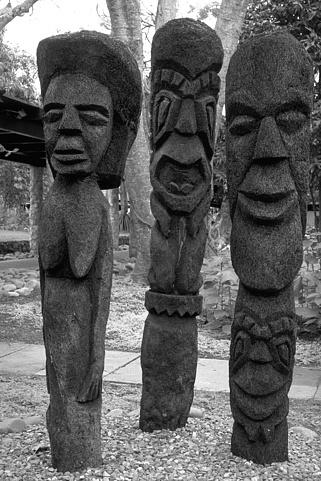
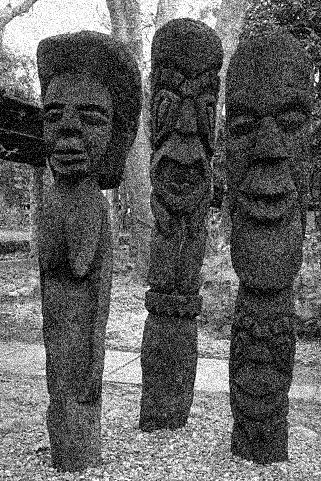
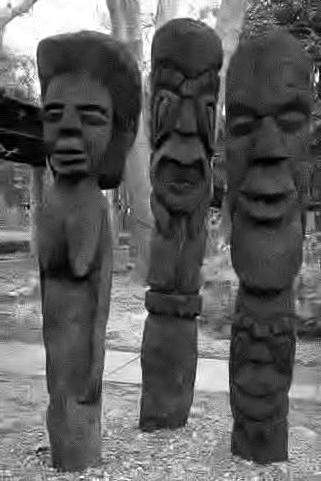

In [10]:
from skimage import io
sigma=30

# creates and initializes a DCTlike network
dctnet = DCTlike(8,sigma,initializeDCT=True, shrinkage='hard')

# load a clean image
img_clean = io.imread('datasets/BSD68/test001.png').astype(np.float32)

# apply the network and visualize the result
_ = test_denoiser(dctnet, img_clean, sigma=sigma, show=True)

**Question 1.** What are the differences between the  `DCTlike` network and the [**single scale DCT denoising** implemented in IPOL](http://www.ipol.im/pub/art/2017/201/)?
1. List the differences.
2. Compare the results obtained with both methods at equal noise level and patch size;  analyze the PSNR,
3. and the artifacts.




<font color=red>**ANSWER TO QUESTION 1**</font>



1. There is no addaptative aggregation in our network

2. Using the same image, and the same $\sigma$ (30) and patch size (8), the IPOL DCT performs slighlty better in terms of PSNR (+0.1 dB)

3. -

# Training functions

Neural networks are trained using a large number of examples. In the case of denoising the examples are pairs of noisy (input) and noiseless (output) images, which are used to automatically infer rules for denoising the images.
For a given pair of noisy and noiseless images $x, y$, the network computes $\tilde y = \text{NET}_\theta(x)$. The training process approximately minimizes the loss $\ell$ for all the examples:
$$ \min_\theta \sum_{(x_i, y_i)\in \text{examples}} \ell( \text{NET}_\theta(x_i), y_i)$$

For learning several elements are needed:
* **data**: a large training set of pairs of noisy and noiseless images
* **network model**: specification of network architecture and parameters 
* **loss function**:  criterion to quantify the error between the denoised and noiseless images
* **optimizer**: updates the model parameters (or weights) according to the gradient of the loss. Its hyperparameters control the learning rate and the regularity such as the weight_decay

These elements will be the inputs of the training.
The training loop consists of an iterative learning process in which the training images are presented to the network in mini-batches. The outputs produced by the network are compared with the corresponding noiseless images according to the loss function.
The network weights are adjusted to minimize the loss using the gradient of the loss over the mini-batch, which is computed using backpropagation.
After all training images are processed, the process starts over again. Each sweep over the training set is called an **epoch**.

### Data preparation

The training dataset will be handled by a torch `DataLoader`, which combines a dataset and a sampler,
and provides iterators over the dataset. For the denoising task the data consists of pairs of noisy/noiseless image patches extracted from a set of images.
For simplicity we provide you with a module `denoising_dataloaders` that implements the function `train_validation_denoising_dataloaders` that given a directory containing noiseless images generates the dataloaders for training and validation.

```python
def train_validation_denoising_dataloaders(imagepath,
                         noise_sigma=30, crop_size=40,
                         train_batch_size=128,
                         val_batch_size=32,
                         validation_split_fraction=0.1)
```

The dataloader will randomly crop patches (of size `crop_size`) from the images, apply a random rotation (of an angle multiple of $\pi/2$), a random reflection and add noise with the specified intensity.  It is important to use two datasets, one for training and another for validation in order to detect overfitting.

#### Let's display the data generated by the dataloader

For training and validation we will be using the images in `./datasets/Train400/`.

Mini-batch 0 containing 64 40x40 crops
Mini-batch 1 containing 64 40x40 crops
Mini-batch 2 containing 64 40x40 crops
Mini-batch 3 containing 64 40x40 crops
Mini-batch 4 containing 64 40x40 crops
Mini-batch 5 containing 40 40x40 crops


A minibatch of noisy patches:


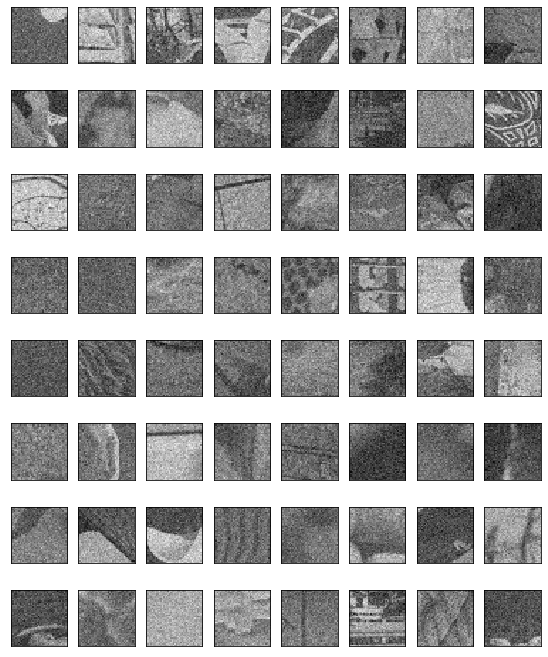



And the corresponding noiseless patches:


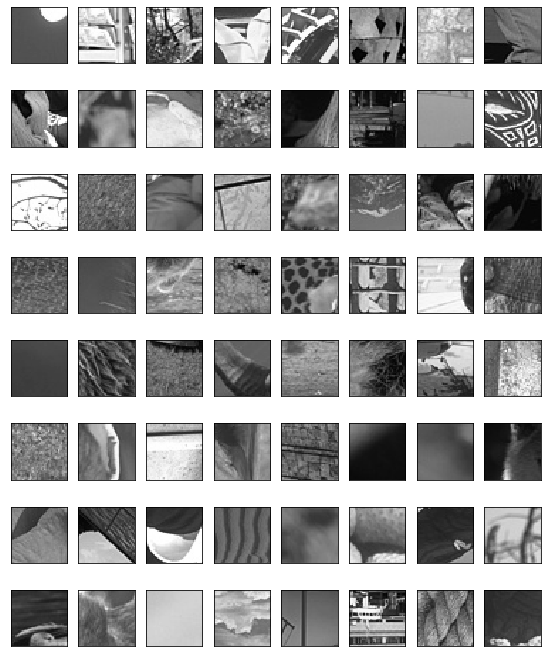

In [7]:
from denoising_dataloaders import train_val_denoising_dataloaders
import vistools

# create the data loader
train_loader, val_loader = \
    train_val_denoising_dataloaders('./datasets/Train400/',
                                     noise_sigma=30,
                                     crop_size=40,
                                     train_batch_size=64)
# print size of the mini-batches
for i, (X,Y) in enumerate(train_loader):
    print('Mini-batch %d containing %d %dx%d crops'
         % (i, Y.size(0), Y.size(2), Y.size(3)))

    
# visualize first mini-batch
X, Y = list(train_loader)[0]

# this helper function displays the patches in the mini-batch
print('\n\nA minibatch of noisy patches:')
vistools.display_patches(X)

print('\n\nAnd the corresponding noiseless patches:')
vistools.display_patches(Y)

### Training loop

In the training loop the network processes mini-batches of training images, apply the model then compares the results against the desired outputs (with the loss). Errors are then back-propagated through the system for the computation of the gradient of the loss with respect to the parameters of the network. This gradient will be used by an optimizer to adjust the the parameters for the next iteration.

To summarize the steps of the learning process:

1. *For each epoch*
    1. *For each minibatch*
        1. *Apply forward model to compute the output*
        2. *Compute the loss on the batch*
        3. *Backpropagate to compute gradients of the loss w.r.t. the learnable model parameters*
        4. *Optimizer updates the model parameters using the gradients computed above*
    2. *Each N epochs compute the loss on the validation dataset*


The function `trainmodel` defined in the following block implements the above algorithm.


We will use the Adam optimizer, which is more sophisticated
than the vanila stochastic gradient descent. To learn more about the
different optimizers you can refer to [the notes of CS231 course
from Stanford University](http://cs231n.github.io/neural-networks-3/#update).

In [8]:
def check_accuracy(model, loss_fn, dataloader):
    """
    Auxiliary function that computes mean of the loss_fn
    over the dataset given by dataloader.

    Args:
        - model: a network
        - loss_fn: loss function
        - dataloader: the validation data loader

    Returns:
        - loss over the validation set
    """
    import torch

    dtype = torch.FloatTensor
    if torch.cuda.is_available():
        model = model.cuda()
        loss_fn = loss_fn.cuda()
        dtype   = torch.cuda.FloatTensor

    loss = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for (x, y) in dataloader:

            # transform mini-batch to tensors
            x_var = x.type(dtype)
            y_var = y.type(dtype)

            # apply model to x mini-batch
            out   = model(x_var)

            # accumulate loss
            loss += loss_fn(out, y_var)

    # return loss divided by number of mini-batches
    return loss/len(dataloader)


def trainmodel(model, loss_fn, loader_train, loader_val=None,
               optimizer=None, scheduler=None, num_epochs = 1,
               learning_rate=0.001, weight_decay=0.0, loss_every=10,
               save_every=10, filename=None):
    """
    function that trains a network model
    Args:
        - model       : network to be trained
        - loss_fn     : loss functions
        - loader_train: dataloader for the training set
        - loader_val  : dataloader for the validation set (default None)
        - optimizer   : the gradient descent method (default None)
        - scheduler   : handles the hyperparameters of the optimizer
        - num_epoch   : number of training epochs
        - learning_rate: learning rate (default 0.001)
        - weight_decay: weight decay regularization (default 0.0)
        - loss_every  : print the loss every n epochs
        - save_every  : save the model every n epochs
        - filename    : base filename for the saved models
    Returns:
        - model          : trained network
        - loss_history   : history of loss values on the training set
        - valloss_history: history of loss values on the validation set
    """
    import torch
    from time import time
    import numpy as np

    dtype = torch.FloatTensor
    # GPU
    if torch.cuda.is_available():
        model   = model.cuda()
        loss_fn = loss_fn.cuda()
        dtype   = torch.cuda.FloatTensor

    if optimizer == None or scheduler == None:
        # Default optimizer and scheduler

        # The optimizer is in charge of updating the parameters
        # of the model. It has hyper-parameters for controlling
        # the gradient update, such as the learning rate (lr) and
        # the regularization such as the weight_decay
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate,
                                     betas=(0.9, 0.999), eps=1e-08,
                                     weight_decay=weight_decay, amsgrad=False)

        # The learning rate scheduler monitors the evolution of the loss
        # and adapts the learning rate to avoid plateaus. We will use
        # a scheduler available in torch that reduces the lr by 'factor'
        # if in the last epochs there hasn't been a significant
        # reduction of the validation loss
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
#                            mode='min', factor=0.5, patience=50,
                            mode='min', factor=0.8, patience=50,
                            verbose=True, threshold=0.0001,
                            threshold_mode='rel', cooldown=0,
                            min_lr=0, eps=1e-08)

    loss_history=[]
    valloss_history=[]
    
    # Display initial training and validation loss
    message=''
    if loader_val is not None:
        valloss = check_accuracy(model, loss_fn, loader_val)
        message = ', val_loss = %.4f' % valloss.item()

    print('Epoch %5d/%5d, ' % (0, num_epochs) +
          'loss = %.4f%s'% (-1, message))

    # Save initial results
    if filename:
        torch.save([model, optimizer, loss_history, valloss_history],
                   filename+'%04d.pt' % 0)

    # Main training loop
    for epoch in range(num_epochs):

        # The data loader iterates once over the whole data set
        for (x, y) in loader_train:
            # make sure that the models is in train mode
            model.train()

            # Apply forward model and compute loss on the batch
            x = x.type(dtype) # Convert data into pytorch 'variables'
            y = y.type(dtype) # for computing the backprop of the loss
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            # Zero out the gradients of parameters that the optimizer
            # will update. The optimizer is already linked to the
            # network parameters.
            optimizer.zero_grad()

            # Backwards pass: compute the gradient of the loss with
            # respect to all the learnable parameters of the model.
            loss.backward()

            # Update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

        # Store loss history to plot it later
        loss_history.append(loss)
        if loader_val is not None:
            valloss = check_accuracy(model, loss_fn, loader_val)
            valloss_history.append(valloss)

        # Display current loss and compute validation loss
        if ((epoch + 1) % loss_every == 0):
            message=''
            if loader_val is not None:
                message = ', val_loss = %.4f' % valloss.item()

            print('Epoch %5d/%5d, ' % (epoch + 1, num_epochs) +
                  'loss = %.4f%s'% (loss.item(), message))

        # Save partial results
        if filename and ((epoch + 1) % save_every == 0):
            torch.save([model, optimizer, loss_history, valloss_history],
                       filename+'%04d.pt' % (epoch + 1))
            print('Epoch %5d/%5d, checkpoint saved' % (epoch + 1, num_epochs))

        # scheduler update
        scheduler.step(loss.data)

    # Save last result
    if filename:
        torch.save([model, optimizer, loss_history, valloss_history],
                    filename+'%04d.pt' % (epoch + 1))

    return model, loss_history, valloss_history

-----------------------------

# Training the DCT-like denoiser

### Train the network

We will now run a few training iterations on our DCT-like denoiser. Use the following code to train a DCT network with 4x4 kernels with the previous training functions. Try starting initializing the network with and without the DCT basis.

Epoch     0/  200, loss = -1.0000, val_loss = 0.0041
Epoch    10/  200, loss = 1.3454, val_loss = 0.3108
Epoch    20/  200, loss = 0.9351, val_loss = 0.0388
Epoch    30/  200, loss = 0.0210, val_loss = 0.3702
Epoch    40/  200, loss = 0.0516, val_loss = 0.0850
Epoch    50/  200, loss = 0.0278, val_loss = 0.0239
Epoch 00052: reducing learning rate of group 0 to 8.0000e-03.
Epoch    60/  200, loss = 0.0101, val_loss = 0.0197
Epoch    70/  200, loss = 0.0081, val_loss = 0.0106
Epoch    80/  200, loss = 0.0062, val_loss = 0.0071
Epoch    90/  200, loss = 0.0058, val_loss = 0.0065
Epoch   100/  200, loss = 0.0050, val_loss = 0.0065
Epoch   100/  200, checkpoint saved
Epoch 00103: reducing learning rate of group 0 to 6.4000e-03.
Epoch   110/  200, loss = 0.0048, val_loss = 0.0056
Epoch   120/  200, loss = 0.0048, val_loss = 0.0055
Epoch   130/  200, loss = 0.0046, val_loss = 0.0052
Epoch   140/  200, loss = 0.0043, val_loss = 0.0046
Epoch   150/  200, loss = 0.0044, val_loss = 0.0048
Epoch 0

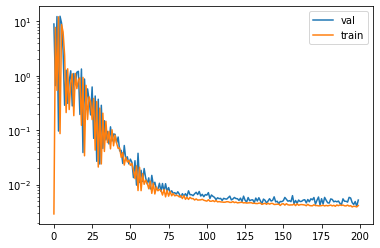

In [13]:
# let us now train from that initial condition

from denoising_dataloaders import train_val_denoising_dataloaders

# nose level
sigma=30

# construct a training and a validation data loader
train_loader, val_loader = train_val_denoising_dataloaders(
                                           './datasets/Train400/',
                                           noise_sigma=sigma,
                                           crop_size=40,
                                           train_batch_size=360)

    
# build dct like network with 4x4 patches and soft shrinkage
dctnet = DCTlike(8,sigma,initializeDCT=True, shrinkage='soft')
#dctnet = DCTlike(4,sigma,initializeDCT=False, shrinkage='soft')
    
    
# define loss
loss = nn.MSELoss()

# run the training loop
filename = persistent_storage+'/DCT8_soft-thr_L2_dct-init_' # for dct initialization
#filename = persistent_storage+'/DCT4_soft-thr_L2_rnd-init_' # for random initialization
dctnet, tloss, vloss, = trainmodel(dctnet, loss, train_loader, val_loader,
                                   num_epochs=200,
                                   learning_rate=1e-2,
                                   save_every=100, loss_every=10,
                                   filename=filename)

# plot loss
plt.semilogy(torch.stack(vloss).cpu().detach(), label='val')
plt.semilogy(torch.stack(tloss).cpu().detach(), label='train')
plt.legend()


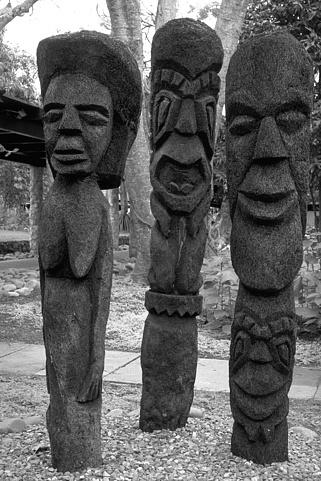
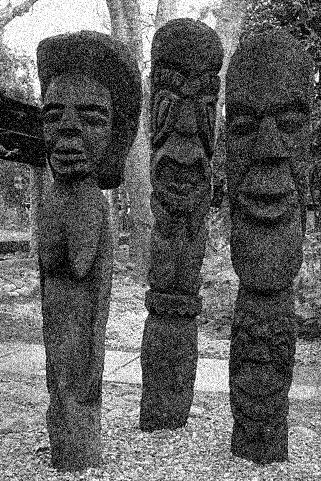
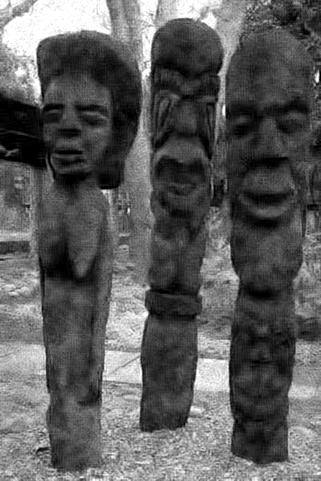

In [14]:
# Visualize the result of the training

sigma=30

# Load the result of the previous trainig
dctnet = torch.load(persistent_storage+'/DCT8_soft-thr_L2_dct-init_0200.pt')[0]

img_clean = io.imread('datasets/BSD68/test001.png').astype(np.float32)
_ = test_denoiser(dctnet, img_clean, sigma=sigma, show=True)

## Result analysis 

**It's no surprise that the above network didn't work very well. 200 epochs might not be enough to converge.**

Let's compare some training results computed with more computational resources. You will find pretrained DCT networks  with 4x4 and 8x8 kernels, initialized with the DCT kernels or randomly. These networks have been trained on a GPU using mini-batches of 360 40x40 crops. When the initialization was random, we used 2000 epochs and an initial learning rate of 1e-3.  Checkpoints were saved every 500 iterations (starting with 0).

You can load these checkpoints using `torch.load`. For example:

`checkpoint = torch.load('pre-trained/DCT8_soft-thr_L2_rnd-init_2000.pt')`

This loads the iteration 2000 during training of a DCT-like network with 8x8 kernels (`DCT8`) and soft threshold non-linearity. The initial condition was a random initialization (`rnd-init`) and the loss was the squared L2 norm (MSE). 

Another example is:

`checkpoint = torch.load('pre-trained/DCT4_soft-thr_L2_dct-init_0500.pt')`

This loads training iteration 500 of a DCT-like net with 4x4 kernels and soft-shrinkage, initialized with the DCT and using the squared L2 loss.

The saved checkpoints are a tuple with the following data:
- `checkpoint[0]`: the dct-like network
- `checkpoint[1]`: the evolution of the training loss
- `checkpoint[2]`: the evolution of the validation loss

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.padding.ReflectionPad2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.activation.Softshrink' has changed. you can retrieve the original source code by accessing the object's source attribut

(0.0010083884473325387, 0.05)

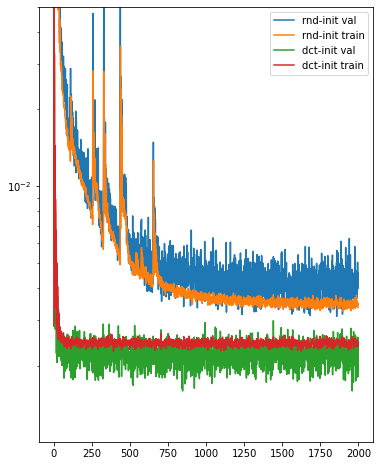

In [15]:
# compare the evolution of the loss

# load last checkpoint
dctnet1 = torch.load('pre-trained/DCT8_soft-thr_L2_rnd-init_2000.pt', map_location={'cuda:0': 'cpu'})

plt.figure(figsize=(6,8))
plt.semilogy(torch.stack(dctnet1[2]).cpu().detach(), label='rnd-init val')
plt.semilogy(torch.stack(dctnet1[1]).cpu().detach(), label='rnd-init train')
plt.legend()


dctnet2 = torch.load('pre-trained/DCT8_soft-thr_L2_dct-init_2000.pt', map_location={'cuda:0': 'cpu'})

plt.semilogy(torch.stack(dctnet2[2]).cpu().detach(), label='dct-init val')
plt.semilogy(torch.stack(dctnet2[1]).cpu().detach(), label='dct-init train')
plt.legend()
plt.ylim(top=0.5e-1)

<font color='yellow'>
**Question 2.** Analyze the plots. 

1. Did the trainings of the two networks overfit? 
2. Which network attained the best results? 
3. Is that expected? How can you explain these differences?
</font>


<font color='red'>**ANSWER TO QUESTION 2** </font>


1. The validation loss is real close to the training one, so we can estimate that there were no overfitting.

2. The network initialized with the DCT parameters achieved consistently better performance.

3. It was to be expected, since this orthogonal transform + thresholding procedure for denoising relies on properties of Fourier transforms like DCT (the image concentrates in the low frequencies). So a randomly initialized network would harshly reach the DCT performance.

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.padding.ReflectionPad2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.activation.Softshrink' has changed. you can retrieve the original source code by accessing the object's source attribut


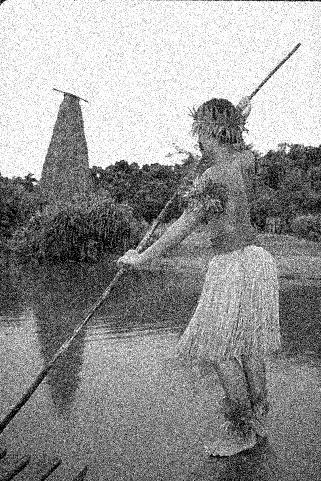
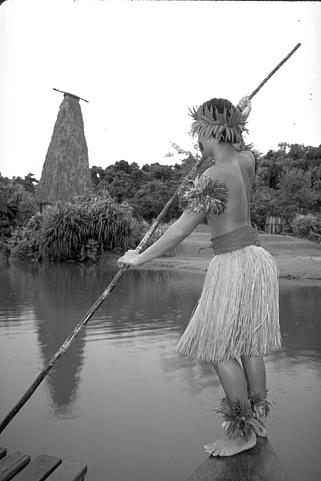
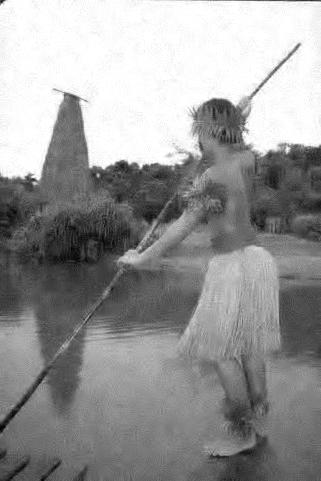
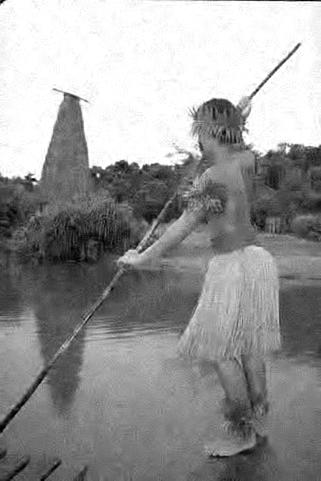
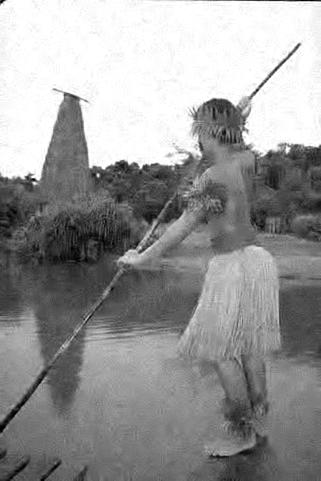
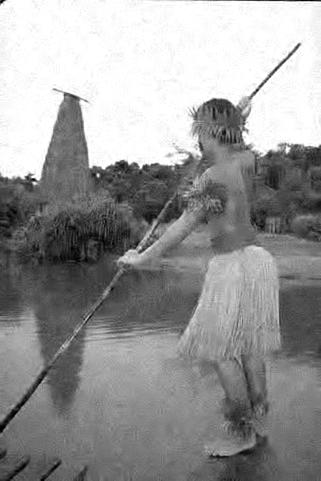
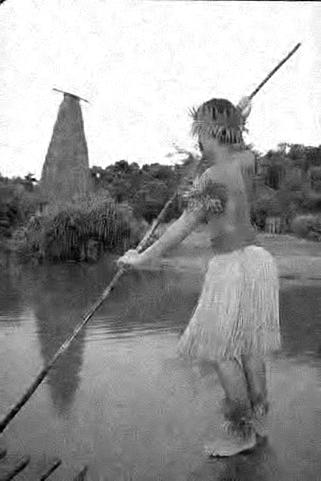
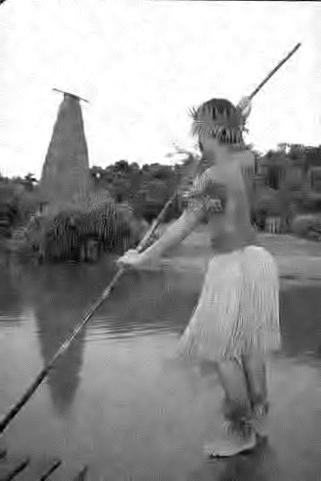

In [16]:
# This cell shows the evolution of the denoising performance during training

from skimage import io

# load an image
img_clean = io.imread('datasets/BSD68/test002.png').astype(np.float32)
img_noisy = img_clean + np.random.normal(0, sigma, img_clean.shape)

outs = []
labels = []

# add noisy image
outs.append(np.array(img_noisy).clip(0,255))
labels.append('noisy')

# add clean image
outs.append(np.array(img_clean).clip(0,255))
labels.append('clean')

# add results of iterations
for i in range(0,2001,500):
    net = torch.load('pre-trained/DCT8_soft-thr_L2_dct-init_%04d.pt' % i, map_location={'cuda:0': 'cpu'})[0]
    out = test_denoiser(net, img_noisy, sigma, has_noise=True)[0]
    outs.append(np.array(out).clip(0,255))
    labels.append('trained dct net - it %d - %f (dB)' % (i, PSNR(out, img_clean)))

# add result of original dct
original_dct = DCTlike(8, sigma, initializeDCT=True)
out = test_denoiser(original_dct, img_noisy, sigma, has_noise=True)[0]
outs.append(np.array(out).clip(0,255))
labels.append('original dct - %f (dB)' % (PSNR(out, img_clean)))


vistools.display_gallery(outs, labels)

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.padding.ReflectionPad2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.activation.Softshrink' has changed. you can retrieve the original source code by accessing the object's source attribut


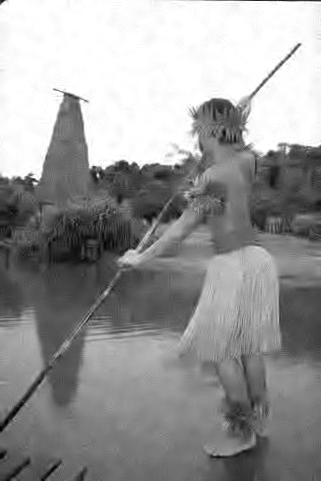
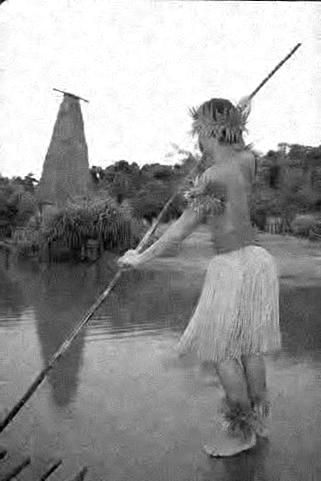
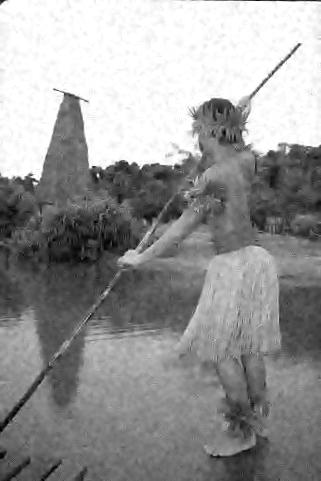
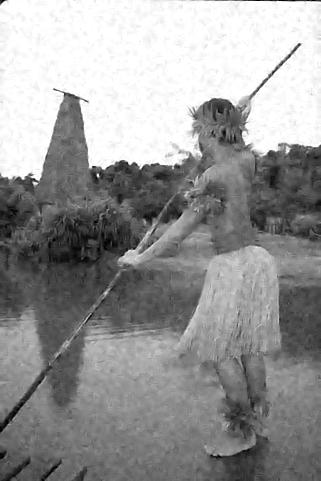
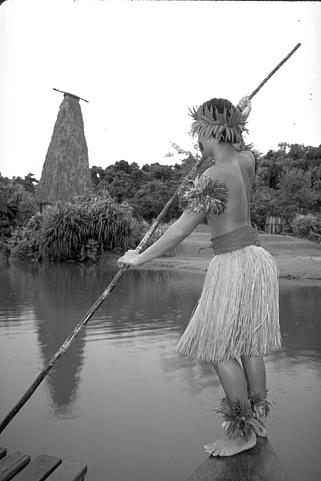
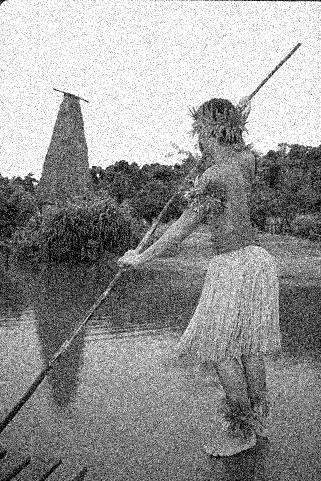

In [11]:
# This cell compares denoising results of different pre-trained networks

from skimage import io

# load denoising nets

# load an image
img_clean = io.imread('datasets/BSD68/test002.png').astype(np.float32)
img_noisy = img_clean + np.random.normal(0, sigma, img_clean.shape)

outs = []
labels = []

# original dct denoising 8x8
original_dct = DCTlike(8, sigma, initializeDCT=True)
out = test_denoiser(original_dct, img_noisy, sigma, has_noise=True)[0]
outs.append(np.array(out).clip(0,255))
labels.append('original dct 8x8 - %f (dB)' % (PSNR(out, img_clean)))

# trained starting from dct 8x8
dctnet1 = torch.load('pre-trained/DCT8_soft-thr_L2_dct-init_1000.pt', map_location={'cuda:0': 'cpu'})[0]
out = test_denoiser(dctnet1, img_noisy, sigma, has_noise=True)[0]
outs.append(np.array(out).clip(0,255))
labels.append('trained from dct 8x8 - %f (dB)' % (PSNR(out, img_clean)))

# original dct denoising 4x4
original_dct = DCTlike(4, sigma, initializeDCT=True)
out = test_denoiser(original_dct, img_noisy, sigma, has_noise=True)[0]
outs.append(np.array(out).clip(0,255))
labels.append('original dct 4x4 - %f (dB)' % (PSNR(out, img_clean)))

# trained starting from dct 4x4
dctnet2 = torch.load('pre-trained/DCT4_soft-thr_L2_dct-init_2000.pt', map_location={'cuda:0': 'cpu'})[0]
out = test_denoiser(dctnet2, img_noisy, sigma, has_noise=True)[0]
outs.append(np.array(out).clip(0,255))
labels.append('trained from dct 4x4 - %f (dB)' % (PSNR(out, img_clean)))

# ... you can add more to the comparison ...

outs.append(np.array(img_clean).clip(0,255))
labels.append('clean')

outs.append(np.array(img_noisy).clip(0,255))
labels.append('noisy')

vistools.display_gallery(outs, labels)

<font color='white'>**Question 3.** Give a brief description (a couple of lines) of the qualitative differences between the original DCT and the trained networks initialized with DCT.</font>

<font color=red>**ANSWER TO QUESTION 3**</font>

The networks initialized with DCT, achieve better performance than the original DCT, which is normal. The outputs from the trained network contain more artifacts, but are more agreable to see to the human eye. They are less blurry and look like natural images, even if they contain artifacts. This is surely the result of using soft thresholding. The thresholding of those networks is more adapted, and they don't brutally remove some frequencies.


<font color='white'>**Question 4.** What are the receptive fields of the DCT-like networks using 4x4 and 8x8 filters? How does this impact on the results? 

*Note: the receptive field is the set of input pixels that affect a single output pixel, usually expressed as $N \times N$.*</font>

<font color=red>**ANSWER TO QUESTION 4**</font>

We have two convolution layers, each having the following parameters:

- kernel size $k = 4$ or $k=8$

- stride $s=1$

If we consider the formula of receptive field for convolutions:

$$R = 1 + \sum_{i=1}^2 s(k-1)$$

So with $4\times 4$ patches we get a receptive field of $7 \times 7$ and with $8 × 8$ patches we get a receptive field of $15 \times 15$

Remind that we're learning on $40 \times 40$ crops, so having receptive field values smaller than $40 \times 40$ is reassuring, else their would have been redudancy and the CNNs would have been uselessly big.

For our denoising application, we want to have the largest receptive field possible, as in the Non-local means algorithm. For example if we're denoising a sky pixel, the more sky pixels we have access to the more we will be able to denoise.


<font color='pink'>**Question 5.** Count the parameters of the DCT-like networks.
</font>

<font color=red>**ANSWER TO QUESTION 5**</font>

Let's list the parameters:

- Conv_in: $k^2$ + 1 parameters per kernel (kernel + bias) and $k^2$ output channels $→$ $(k^2+1) \times k^2$ parameters

- Threshold: one per channel $→$ $k^2$ parameters

- Conv_out: $k^2$ input channels $→$  $k^2 \times k^2 +1$

For $k=8$ and with random initialized network (so with bias), we get to 8321 parameters.

INPUT FILTERS


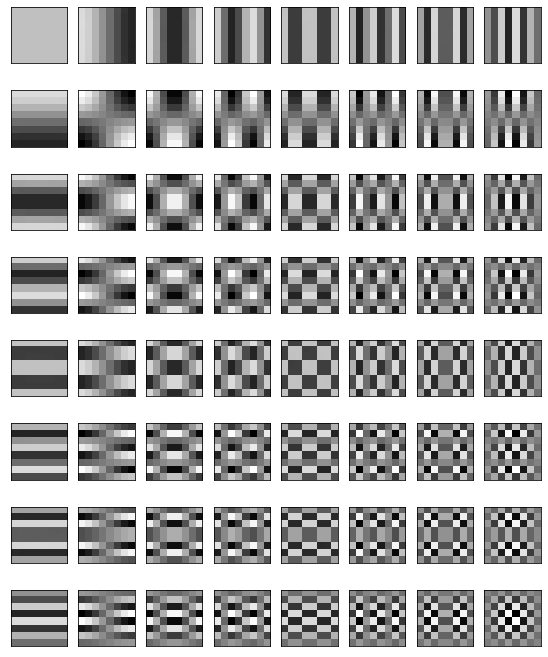

OUTPUT FILTERS


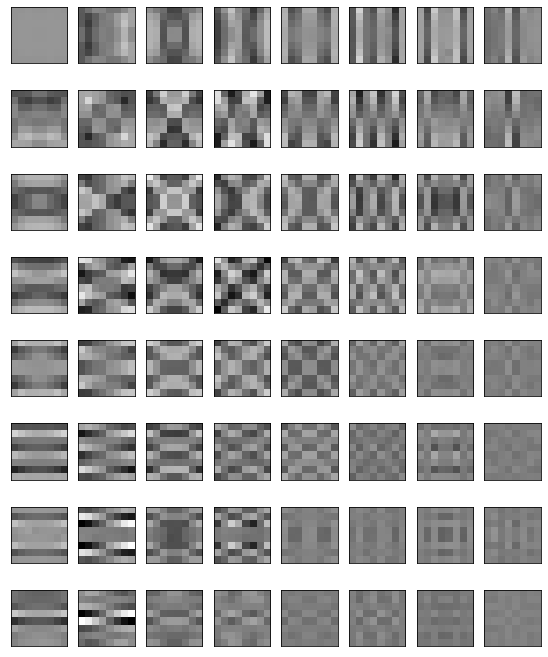

In [12]:
# This cell displays the input and output filters of a network

# load a network
dctnet = torch.load('pre-trained/DCT8_soft-thr_L2_rnd-init_2000.pt', map_location={'cuda:0': 'cpu'})[0]
dctnet = torch.load('pre-trained/DCT8_soft-thr_L2_dct-init_1000.pt', map_location={'cuda:0': 'cpu'})[0]

# Access the network weights and extract the filters numbering them
N = dctnet.conv_in.weight.shape[0]
w_in  = [ dctnet.conv_in .weight[i,0,:,:].detach().cpu().numpy() for i in range(N) ]
w_out = [ dctnet.conv_out.weight[0,i,:,:].detach().cpu().numpy() for i in range(N) ]

print ('INPUT FILTERS')
vistools.display_patches(w_in)

print ('OUTPUT FILTERS')
vistools.display_patches(w_out)

# A deeper architecture

We will now work with **DnCNN** a deep convolutional network with a simple architecutre introduced by

*K. Zhang, W. Zuo, Y. Chen, D. Meng, and L. Zhang, “Beyond a Gaussian Denoiser: Residual Learning of Deep CNN for Image Denoising,” IEEE Trans. Image Process., vol. 26, no. 7, pp. 3142–3155, Jul. 2017.*

The network has several hidden layers, all of them equal: convolution, **batch normalization** and **ReLU activations** and uses **residual learning**. All convolutions have the same size (the authors used 3x3).

<img width=700 src="https://www.researchgate.net/profile/Yunjin_Chen/publication/306187437/figure/fig4/AS:667093628379148@1536058923422/The-architecture-of-the-proposed-DnCNN-network.png"/>


The code below declares the DnCNN network. 
An instance of the network for grayscale images is created with `model = DnCNN(1,1)` where the parameters `1` indicate the number of input and output channels.
The model is made of atomic blocks such as `nn.Conv2d`, whch represents a convolutional layer. Note how the layers are declared in the `__init__` method of each model and then called in `forward`. 

A newly created network is initialized with random weights.

In [13]:
import torch
import torch.nn as nn


class CONV_BN_RELU(nn.Module):
    '''
    PyTorch Module grouping together a 2D CONV, BatchNorm and ReLU layers.
    This will simplify the definition of the DnCNN network.
    '''

    def __init__(self, in_channels=128, out_channels=128, kernel_size=7, 
                 stride=1, padding=3):
        '''
        Constructor
        Args:
            - in_channels: number of input channels from precedding layer
            - out_channels: number of output channels
            - kernel_size: size of conv. kernel
            - stride: stride of convolutions
            - padding: number of zero padding
        Return: initialized module
        '''
        super(__class__, self).__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, 
                              stride=stride, padding=padding)
        self.bn   = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        '''
        Applies the layer forward to input x
        '''
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        
        return(out)



class DnCNN(nn.Module):
    '''
    PyTorch module for the DnCNN network.
    '''

    def __init__(self, in_channels=1, out_channels=1, num_layers=17, 
                 features=64, kernel_size=3, residual=True):
        '''
        Constructor for a DnCNN network.
        Args:
            - in_channels: input image channels (default 1)
            - out_channels: output image channels (default 1)
            - num_layers: number of layers (default 17)
            - num_features: number of hidden features (default 64)
            - kernel_size: size of conv. kernel (default 3)
            - residual: use residual learning (default True)
        Return: network with randomly initialized weights
        '''
        super(__class__, self).__init__()
        
        self.residual = residual
        
        # a list for the layers
        self.layers = []  
        
        # first layer 
        self.layers.append(CONV_BN_RELU(in_channels=in_channels,
                                        out_channels=features,
                                        kernel_size=kernel_size,
                                        stride=1, padding=kernel_size//2))
        # intermediate layers
        for _ in range(num_layers-2):
            self.layers.append(CONV_BN_RELU(in_channels=features,
                                            out_channels=features,
                                            kernel_size=kernel_size,
                                            stride=1, padding=kernel_size//2))
        # last layer 
        self.layers.append(nn.Conv2d(in_channels=features,
                                     out_channels=out_channels,
                                     kernel_size=kernel_size,
                                     stride=1, padding=kernel_size//2))
        # chain the layers
        self.dncnn = nn.Sequential(*self.layers)

        
    def forward(self, x):
        ''' Forward operation of the network on input x.'''
        out = self.dncnn(x)
        
        if self.residual: # residual learning
            out = x - out 
        
        return(out)



<font color=green>**Question 6.** The following architecture achieves state-of-the-art results (when trained). For the network described below, 
1. **count the number of parameters the network** 
2. and determine the **size of its receptive field**.

`m = DnCNN(in_channels=1, out_channels=1, num_layers=17, features=64, kernel_size=3)`</font>

<font color='red'>**ANSWER TO QUESTION 6** </font>

- First conv: $(1\times 3^2 + 1)\times 64$
- First batch norm: $2 \times 64$
- 15 nexts conv: $15 \times \big( (64 \times 3^2 + 1) \times 64 \big)$
- 15 batch norm: $ 15 \times 2 \times 64$
- Last conv: $64 \times 3^2 +1$

Which leads to a total of: 557185 parameters

It's receptive field is: 

$$1 + \sum_{j=1}^{17}(k-1) = 1+ 2\times 17 =35$$

So the receptive field is $35 \times 35$




In [14]:
640 + 128 + 15 * (64*(64*9+1)) + 30*64 + 64*9+1

557185

### Teaser: apply a state-of-the-art network

Let's first load a state-of-the-art denoising network, just to see what a deep network is capable of. We will load the network parameters trained by the authors of DnCNN, and test it on an image. Compare it with the result of our best DCT denoising network.

downloading pretrained models



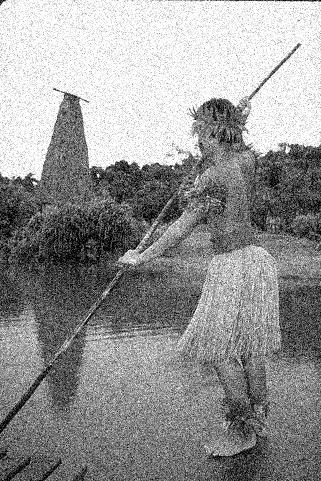
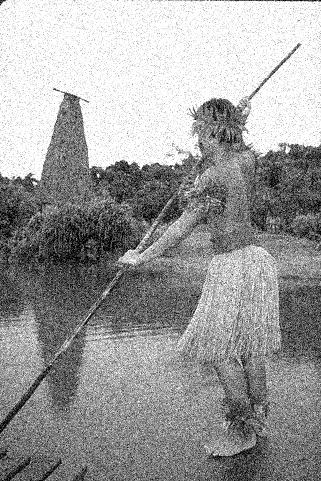
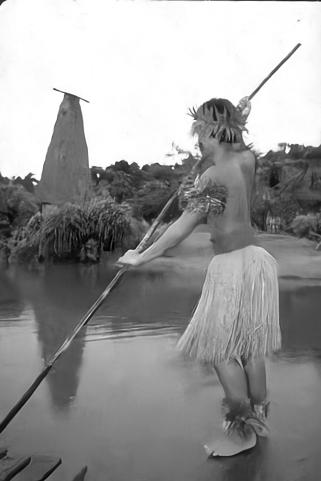
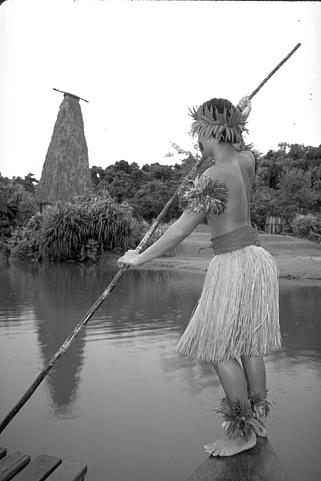

In [15]:
from models import DnCNN_pretrained #, DnCNN
from denoising_helpers import test_denoiser, PSNR
from skimage import io
import vistools

# load an image (change the number to test other images)
image = io.imread('datasets/BSD68/test002.png').astype(np.float32)


# set a noise level
sigma = 30

# add noise
im_clean = image.astype('float32')
im_noisy = im_clean + np.random.normal(0, sigma, im_clean.shape)

# load two versions of DnCNN: random weights and trained weights
dncnn_random = DnCNN(in_channels=1, out_channels=1, num_layers=17, features=64, kernel_size=3, residual=True)
dncnn_trained = DnCNN_pretrained(sigma)

# apply them to the image
out_random  = test_denoiser(dncnn_random , im_noisy, sigma, has_noise=True)[0]
out_trained = test_denoiser(dncnn_trained, im_noisy, sigma, has_noise=True)[0]

# compute PSNRs
PSNR_noisy   = PSNR(im_noisy   , im_clean)
PSNR_random  = PSNR(out_random , im_clean)
PSNR_trained = PSNR(out_trained, im_clean)

# show as a gallery
vistools.display_gallery([np.array(im_noisy   ).clip(0,255),
                          np.array(out_random ).clip(0,255),
                          np.array(out_trained).clip(0,255),
                          np.array(im_clean   ).clip(0,255)],
                         ['noisy  (%.2f dB)' % PSNR_noisy,
                          'denoised random  weights (%.2f dB)' % PSNR_random,
                          'denoised trained weights (%.2f dB)' % PSNR_trained,
                          'clean'])

<font color=blue>**Question 7.** It is no surprise that DnCNN is much better than DCT, it has a much larger receptive field and number of parameters. What would be the number of layers (network depth) of a DnCNN network using 3x3 kernels so that its receptive field matches that of our DCT-like network with 8x8 patches?</font>

We want to have:

$ 1 + 2n = 15 $

So we would have to use 7 layers.

<font color='red'>**ANSWER TO QUESTION 7** </font>


<font color=white>**Question 8.**  For the number of layers  computed in the previous question, compute the number of features of the hidden layers that result in a parameter count that roughly matches that of the DCT8 network. </font>

<font color='red'>**ANSWER TO QUESTION 8** </font>
 
 We want to have (without biases):

$$ 16n + 10n + 5n(9n+1) +10n +9n+1 = 8321 $$

$$ 45n^2 + 45n = 8320$$

$$ n(n+1)= 184$$

$$ n ≈ 13 $$

We would have to use 13 features.

### Train a tiny DnCNN

Let's do a fair comparison of the deep  architecture of DnCNN and the shallow DCTlike network using 8x8 patches. Use the parameters computed in the question above to ensure that both networks have the same receptive field and number of parameters.


**Question 9.**
Fill-in the parameters computed above (network depth and number of features) in the code block below and train the network. We recommend running 1000 or 2000 epochs. 
0. Fill-in the network parameters.
1. Count the number of parameters of the resulting network.
2. Run the remaining blocks to train the network. 
3. Compare the result with DCTlike 8x8.
4. Change the weight initialization with the one commented in the code. Do you observe any improvement? Can you explain it?  




<font color='red'>**ANSWER TO QUESTION 9** </font>

Though having rouhgly the same number of parameters and the same receptive field, the tiny DnCNN outperforms the DCT denoiser, by 0.8 db of PSNR.

Modifying the weight initialization using Kaiming does not seem to change that much the results, but it does change the learning process, because we don't have to decrease the learning rate te $10^{-6}$ but only to $10^{-4}$

Epoch     0/ 2000, loss = -1.0000, val_loss = 0.0203
Epoch    10/ 2000, loss = 0.0038, val_loss = 0.0147
Epoch    20/ 2000, loss = 0.0033, val_loss = 0.0119
Epoch    30/ 2000, loss = 0.0027, val_loss = 0.0055
Epoch    40/ 2000, loss = 0.0026, val_loss = 0.0033
Epoch    50/ 2000, loss = 0.0025, val_loss = 0.0025
Epoch    60/ 2000, loss = 0.0023, val_loss = 0.0024
Epoch    70/ 2000, loss = 0.0024, val_loss = 0.0027
Epoch    80/ 2000, loss = 0.0024, val_loss = 0.0025
Epoch    90/ 2000, loss = 0.0023, val_loss = 0.0021
Epoch   100/ 2000, loss = 0.0025, val_loss = 0.0026
Epoch   110/ 2000, loss = 0.0021, val_loss = 0.0024
Epoch   120/ 2000, loss = 0.0022, val_loss = 0.0024
Epoch   130/ 2000, loss = 0.0023, val_loss = 0.0024
Epoch   140/ 2000, loss = 0.0023, val_loss = 0.0023
Epoch   150/ 2000, loss = 0.0022, val_loss = 0.0028
Epoch   160/ 2000, loss = 0.0022, val_loss = 0.0025
Epoch   170/ 2000, loss = 0.0022, val_loss = 0.0024
Epoch   180/ 2000, loss = 0.0021, val_loss = 0.0026
Epoch 00183

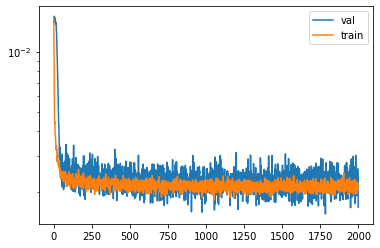

In [22]:
from denoising_dataloaders import train_val_denoising_dataloaders
from training import trainmodel
from models import DnCNN
from torch import nn


sigma=30

# data
trainloader, validationloader = train_val_denoising_dataloaders(
                                            './datasets/Train400/', 
                                            noise_sigma=sigma, crop_size=40, 
                                            train_batch_size=180 )


# network model TO COMPLETE
Denoiser = DnCNN(in_channels=1, out_channels=1, 
                 num_layers=7,#... [COMPLETE WITH RESULT OF QUESTION 6] ...  
                 features=13,  #... [COMPLETE WITH RESULT OF QUESTION 7] ... 
                 kernel_size=3, 
                 residual=True)


# initialize the weights
def weights_init_kaiming(m):
    import math
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('Linear') != -1:
        nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(mean=0, std=math.sqrt(2./9./64.)).clamp_(-0.025,0.025)
        nn.init.constant_(m.bias.data, 0.0)

## apply Kaiming normal weight initialization  
## see: https://pouannes.github.io/blog/initialization/       
#Denoiser.apply(weights_init_kaiming)


# loss
loss = nn.MSELoss()


# run the training loop
Denoiser, loss, lossv, = trainmodel(Denoiser, loss, trainloader, validationloader, 
                                    num_epochs=1000, save_every=250, loss_every=10,  
                                    learning_rate=.01, weight_decay=0.00001,
                                    filename=persistent_storage+'/tiny_DnCNN_')


# plot loss
plt.semilogy(torch.stack(lossv).cpu().detach(), label='val')
plt.semilogy(torch.stack(loss).cpu().detach(), label='train')
plt.legend()

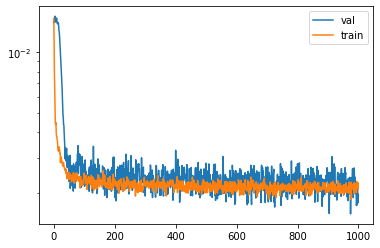

In [23]:
# compare the evolution of the loss
import torch
import matplotlib.pyplot as plt

# load last checkpoint
dctnet1 = torch.load(persistent_storage+'/tiny_DnCNN_1000.pt')

# plot loss
plt.semilogy(torch.stack(dctnet1[2]).cpu().detach(), label='val')
plt.semilogy(torch.stack(dctnet1[1]).cpu().detach(), label='train')
plt.legend()


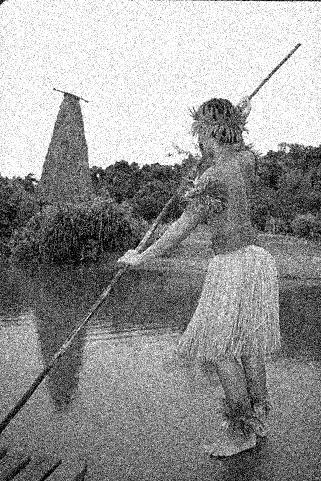
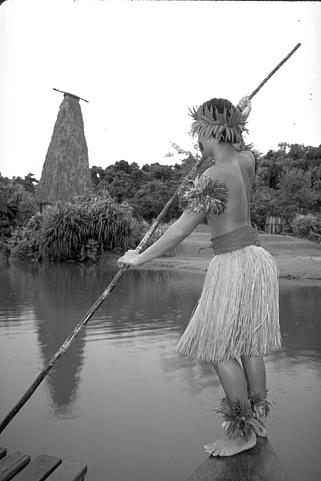
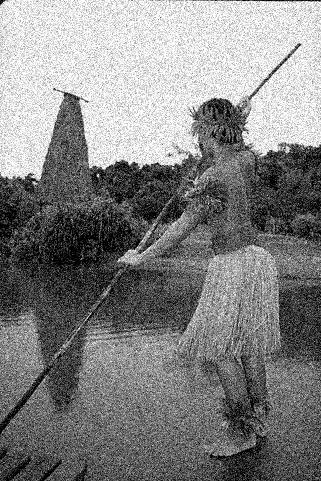
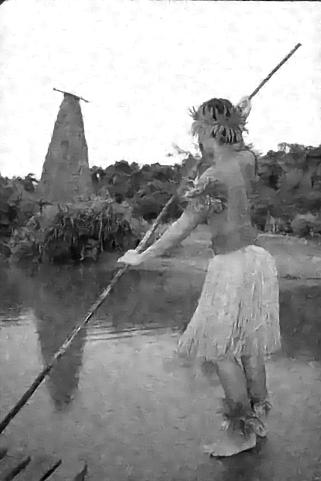
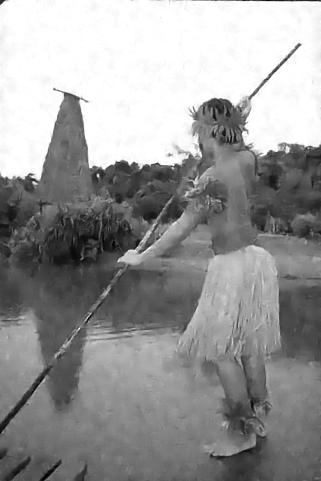
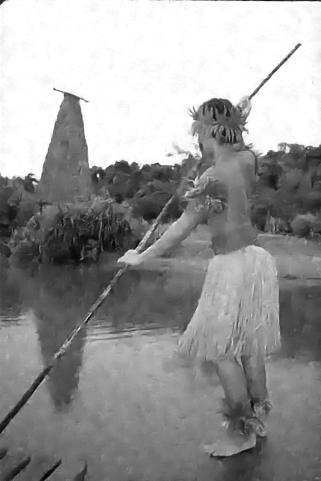
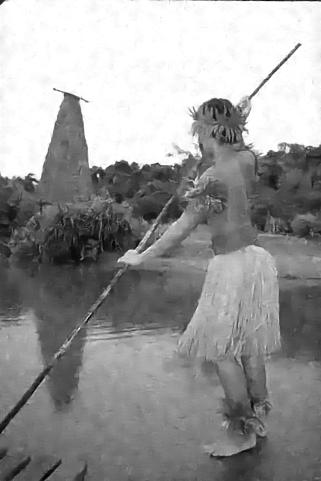
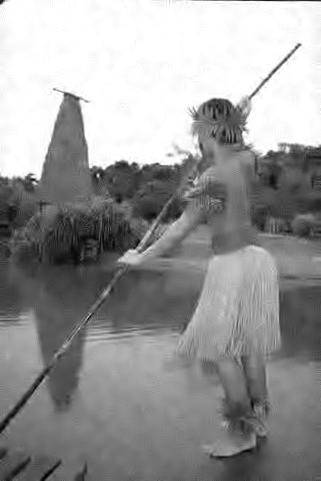

In [24]:
# evolution of the denoising performance during training

from skimage import io
from models import DCTlike

# load an image
img_clean = io.imread('datasets/BSD68/test002.png').astype(np.float32)
img_noisy = img_clean + np.random.normal(0, sigma, img_clean.shape)

outs = []
labels = []

# add noisy image
outs.append(np.array(img_noisy).clip(0,255))
labels.append('noisy')

# add clean image
outs.append(np.array(img_clean).clip(0,255))
labels.append('clean')

# add results of iterations
for i in range(0,1001,250):
    net = torch.load(persistent_storage+'/tiny_DnCNN_%04d.pt' % i)[0]
    out = test_denoiser(net, img_noisy, sigma, has_noise=True)[0]
    outs.append(np.array(out).clip(0,255))
    labels.append('trained tiny DnCNN - it %d - %f (dB)' % (i, PSNR(out, img_clean)))


# add result of original dct
original_dct = DCTlike(8, sigma, initializeDCT=True)
out = test_denoiser(original_dct, img_noisy, sigma, has_noise=True)[0]
outs.append(np.array(out).clip(0,255))
labels.append('original dct - %f (dB)' % (PSNR(out, img_clean)))


vistools.display_gallery(outs, labels)

---------------------------
[//]: # (© 2018 Gabriele Facciolo and Pablo Arias)
[//]: # (<div style="text-align:center; font-size:75%;"> Copyright © 2018 Gabriele Facciolo and Pablo Arias. All rights reserved.</div> )

Epoch     0/ 1000, loss = -1.0000, val_loss = 0.0162
Epoch    10/ 1000, loss = 0.0040, val_loss = 0.0139
Epoch    20/ 1000, loss = 0.0032, val_loss = 0.0109
Epoch    30/ 1000, loss = 0.0027, val_loss = 0.0053
Epoch    40/ 1000, loss = 0.0025, val_loss = 0.0034
Epoch    50/ 1000, loss = 0.0024, val_loss = 0.0027
Epoch    60/ 1000, loss = 0.0025, val_loss = 0.0027
Epoch    70/ 1000, loss = 0.0024, val_loss = 0.0026
Epoch    80/ 1000, loss = 0.0023, val_loss = 0.0025
Epoch    90/ 1000, loss = 0.0023, val_loss = 0.0024
Epoch   100/ 1000, loss = 0.0023, val_loss = 0.0024
Epoch   110/ 1000, loss = 0.0024, val_loss = 0.0027
Epoch   120/ 1000, loss = 0.0022, val_loss = 0.0023
Epoch   130/ 1000, loss = 0.0024, val_loss = 0.0025
Epoch   140/ 1000, loss = 0.0022, val_loss = 0.0026
Epoch   150/ 1000, loss = 0.0024, val_loss = 0.0022
Epoch 00159: reducing learning rate of group 0 to 8.0000e-03.
Epoch   160/ 1000, loss = 0.0022, val_loss = 0.0022
Epoch   170/ 1000, loss = 0.0024, val_loss = 0.0022
E

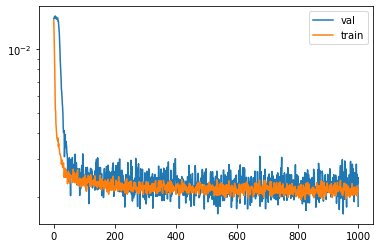

In [25]:
Denoiser = DnCNN(in_channels=1, out_channels=1, 
                 num_layers=7,#... [COMPLETE WITH RESULT OF QUESTION 6] ...  
                 features=13,  #... [COMPLETE WITH RESULT OF QUESTION 7] ... 
                 kernel_size=3, 
                 residual=True)

Denoiser.apply(weights_init_kaiming)


# loss
loss = nn.MSELoss()


# run the training loop
Denoiser, loss, lossv, = trainmodel(Denoiser, loss, trainloader, validationloader, 
                                    num_epochs=1000, save_every=250, loss_every=10,  
                                    learning_rate=.01, weight_decay=0.00001,
                                    filename=persistent_storage+'/tiny_DnCNN_')


# plot loss
plt.semilogy(torch.stack(lossv).cpu().detach(), label='val')
plt.semilogy(torch.stack(loss).cpu().detach(), label='train')
plt.legend()


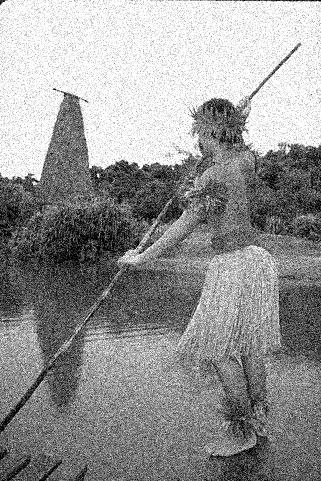
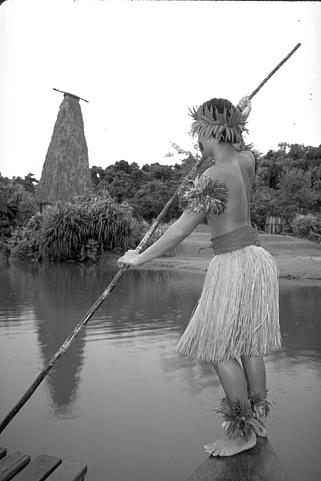
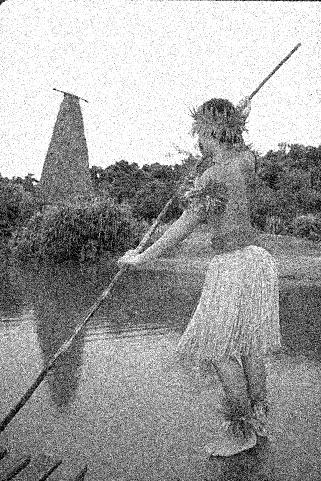
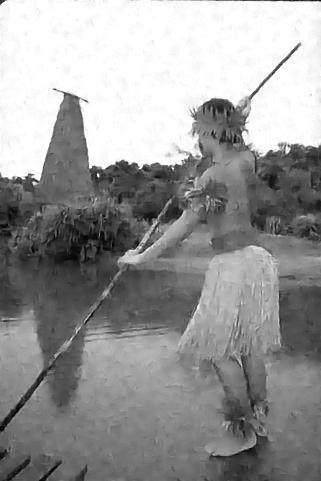
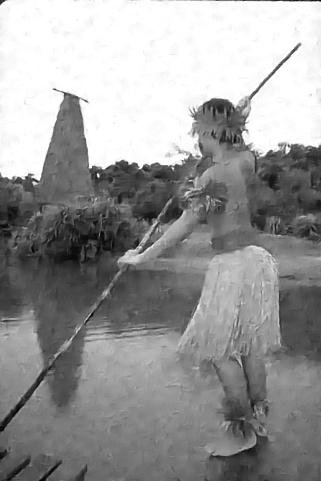
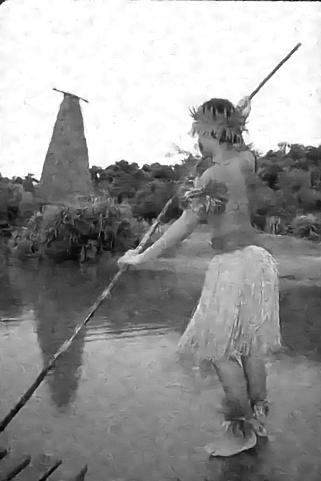
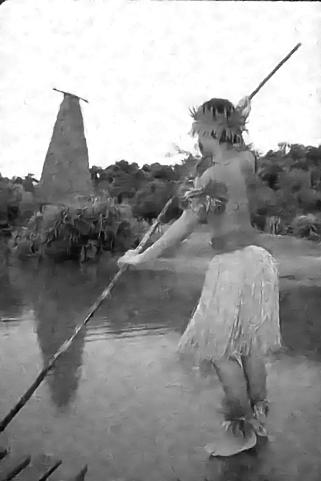
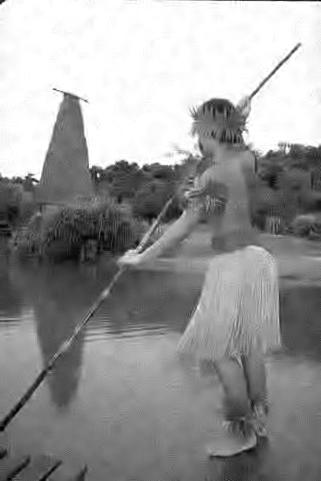

In [26]:
# load an image
img_clean = io.imread('datasets/BSD68/test002.png').astype(np.float32)
img_noisy = img_clean + np.random.normal(0, sigma, img_clean.shape)

outs = []
labels = []

# add noisy image
outs.append(np.array(img_noisy).clip(0,255))
labels.append('noisy')

# add clean image
outs.append(np.array(img_clean).clip(0,255))
labels.append('clean')

# add results of iterations
for i in range(0,1001,250):
    net = torch.load(persistent_storage+'/tiny_DnCNN_%04d.pt' % i)[0]
    out = test_denoiser(net, img_noisy, sigma, has_noise=True)[0]
    outs.append(np.array(out).clip(0,255))
    labels.append('trained tiny DnCNN - it %d - %f (dB)' % (i, PSNR(out, img_clean)))


# add result of original dct
original_dct = DCTlike(8, sigma, initializeDCT=True)
out = test_denoiser(original_dct, img_noisy, sigma, has_noise=True)[0]
outs.append(np.array(out).clip(0,255))
labels.append('original dct - %f (dB)' % (PSNR(out, img_clean)))


vistools.display_gallery(outs, labels)